# 6 Layer Neural Network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import copy
import time

In [2]:
torch.manual_seed(10)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [3]:
device

device(type='mps')

In [4]:
mean = (0.4914, 0.4822, 0.4465)
std_dev = (0.2023, 0.1994, 0.2010)

In [5]:
# transform1 = transforms.Compose([
#     transforms.AutoAugment(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean,std_dev)
# ])
transform2 = transforms.Compose([
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.RandomPerspective(distortion_scale=0.1, p=1.0),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,4),
    transforms.ToTensor(),
    transforms.Normalize(mean,std_dev)
])
transform3 = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.1, p=1.0),
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.RandomHorizontalFlip(),
    transforms.AugMix(),
    transforms.ToTensor(),
    transforms.Normalize(mean,std_dev)
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std_dev)
])

In [6]:
# train_data = torchvision.datasets.CIFAR10(
#     root='../datasets',
#     train = True,
#     transform=transform1 #download is False in default
# )
train_data2 = torchvision.datasets.CIFAR10(
    root='../datasets',
    train = True,
    transform=transform2 #download is False in default
)
train_data3 = torchvision.datasets.CIFAR10(
    root='../datasets',
    train = True,
    transform=transform3 #download is False in default
)

test_data = torchvision.datasets.CIFAR10(
    root='../datasets',
    train = False,
    transform=transform_test
)

In [7]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
train_data = train_data2

In [9]:
# train_data = train_data.__add__(train_data2)
train_data = train_data.__add__(train_data3)

In [10]:
len(train_data)

100000

In [11]:
num_epochs = 30
batch_size = 512
learning_rate = 1e-3

In [12]:
train_loader = torch.utils.data.DataLoader(
    dataset = train_data,
    batch_size = batch_size,
    shuffle = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_data,
    batch_size = batch_size,
    shuffle = True
)

In [13]:
len(train_loader)

196

In [14]:
def imshow(img):
    img = img * np.average(std_dev) + np.average(mean)  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Transpose along the axes (1,2,0)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


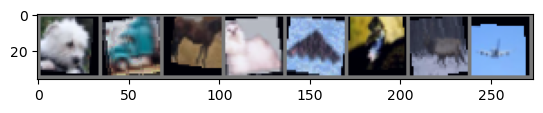

dog
truck
horse
dog
plane
bird
deer
plane


In [15]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:8]))
for i in labels[:8]:
    print(classes[int(i)])

In [16]:
images.shape

torch.Size([512, 3, 32, 32])

In [17]:
class myResNet(nn.Module):
    def __init__(self) -> None:
        super(myResNet, self).__init__()

        self.conv1 = nn.Conv2d(3,4,5,1,'same') # 4, 32, 32
        # self.act1_1 = nn.ReLU() 
        self.norm1 = nn.BatchNorm2d(4)

        self.conv2 = nn.Conv2d(4,16,5,1,'same') # 16, 32, 32
        self.conv1to2 = nn.Conv2d(3,16,3,1,'same') # 16, 32, 32
        # self.act1_2 = nn.ReLU()
        self.norm2 = nn.BatchNorm2d(16)
            
        self.pool1 = nn.MaxPool2d(2, 2) # 16, 32, 32 --> 16, 16, 16
        
        self.conv3 = nn.Conv2d(16,64,3,1,'same') # 64, 16, 16
        self.conv1to3 = nn.Conv2d(3,64,3,2,1) # 64, 16, 16
        # self.act2_1 = nn.ReLU()
        self.norm3 = nn.BatchNorm2d(64)
            
        self.conv4 = nn.Conv2d(64,256,3,1,'same')  # 256, 16, 16
        self.conv1to4 = nn.Conv2d(3,256,3,2,1) # 256, 16, 16
        # self.act2_2 = nn.ReLU()
        self.norm4 = nn.BatchNorm2d(256)
        
        self.pool2 = nn.MaxPool2d(2, 2) # 256, 16, 16 --> 256, 8, 8

        self.flatten = nn.Flatten()

        self.conv_flatten = nn.Conv2d(3,1,3,1,'same')

        self.lin5 = nn.Linear(256*8*8, 200)
        self.lin1to5 = nn.Linear(32*32, 200)
        # self.act4 = nn.ReLU()
        self.norm5 = nn.BatchNorm1d(200)

        self.lin6 = nn.Linear(200, 85)
        self.lin1to6 = nn.Linear(32*32, 85)
        # self.act5 = nn.ReLU()
        self.norm6 = nn.BatchNorm1d(85)

        self.lin_fin = nn.Linear(85,10)
    
    def forward(self, x):
        x_temp1 = x
        x = self.norm1(torch.relu(self.conv1(x)))
        
        x_temp2 = x
        x = self.norm2(torch.relu(self.conv2(x)+self.conv1to2(x_temp1))) # Residual

        x_temp3 = x
        x = self.pool1(x)

        x = self.norm3(torch.relu(self.conv3(x)+self.conv1to3(x_temp1)))

        x_temp4 = x
        x = self.norm4(torch.relu(self.conv4(x)+self.conv1to4(x_temp1))) # Residual

        x_temp5 = x
        x = self.pool2(x)

        x = self.flatten(x)

        x = self.norm5(torch.relu(self.lin5(x)+F.dropout(self.lin1to5(self.flatten(self.conv_flatten(x_temp1))), p=0.5)))

        x_temp6 = x
        x = self.norm6(torch.relu(self.lin6(x)+F.dropout(self.lin1to6(self.flatten(self.conv_flatten(x_temp1))), p=0.4)))
        x = self.lin_fin(x)
        return(x)

In [18]:
resnet = myResNet().to(device)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 6, gamma = 0.5)

In [20]:
summary(copy.deepcopy(resnet).to('cpu'), (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 32, 32]             304
       BatchNorm2d-2            [-1, 4, 32, 32]               8
            Conv2d-3           [-1, 16, 32, 32]           1,616
            Conv2d-4           [-1, 16, 32, 32]             448
       BatchNorm2d-5           [-1, 16, 32, 32]              32
         MaxPool2d-6           [-1, 16, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]           9,280
            Conv2d-8           [-1, 64, 16, 16]           1,792
       BatchNorm2d-9           [-1, 64, 16, 16]             128
           Conv2d-10          [-1, 256, 16, 16]         147,712
           Conv2d-11          [-1, 256, 16, 16]           7,168
      BatchNorm2d-12          [-1, 256, 16, 16]             512
        MaxPool2d-13            [-1, 256, 8, 8]               0
          Flatten-14                [-1

In [21]:
best_weights = copy.deepcopy(resnet.state_dict())
max = 0
val_acc = 0
train_acc = 0
tic = time.time()
for epoch in range(num_epochs):
    resnet.train()
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        preds = resnet.forward(images)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step() # Decaying learning rate per 25 epochs by 0.2 times
    print(f'Epoch {epoch+1}/{num_epochs}; Loss = {loss.item():.6f}; LR = {scheduler.get_last_lr()}')
    with torch.no_grad():
        n_samples = 0
        n_correct = 0
        resnet.eval()
        for images, labels in test_loader:
            images = images.to(device) # From 128, 1, 28, 28 ---> 128, 784
            labels = labels.to(device)
            pred_outputs1 = resnet(images)
            _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
            n_samples += labels.shape[0]
            n_correct += (actual_preds1 == labels).sum().item()
        val_acc = n_correct/n_samples * 100

        if (max <= (n_correct/n_samples * 100)):
            print('SAVED MODEL WEIGHTS')
            max = val_acc
            best_weights = copy.deepcopy(resnet.state_dict())

        n_samples = 0
        n_correct = 0
        
        for images, labels in train_loader:
            images = images.to(device) # From 128, 1, 28, 28 ---> 128, 784
            labels = labels.to(device)
            pred_outputs1 = resnet(images)
            _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
            n_samples += labels.shape[0]
            n_correct += (actual_preds1 == labels).sum().item()
        train_acc = n_correct/n_samples * 100
    
    print(f'Train Accuracy: {train_acc:.2f}%')
    print(f'Dev Accuracy: {val_acc:.2f}%')
    print("-"*20)
print('Finished Training!')
print(f'Best Test Accuracy = {max}')
print(f'Time Taken = {(time.time()-tic)//60}m {(time.time()-tic)%60}s')

Epoch 1/50; Loss = 1.106465; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 59.88%
Dev Accuracy: 61.91%
--------------------
Epoch 2/50; Loss = 0.872202; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 68.73%
Dev Accuracy: 70.35%
--------------------
Epoch 3/50; Loss = 0.745018; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 73.41%
Dev Accuracy: 73.87%
--------------------
Epoch 4/50; Loss = 0.514394; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 77.36%
Dev Accuracy: 76.63%
--------------------
Epoch 5/50; Loss = 0.656314; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 79.35%
Dev Accuracy: 78.07%
--------------------
Epoch 6/50; Loss = 0.504927; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 81.57%
Dev Accuracy: 80.46%
--------------------
Epoch 7/50; Loss = 0.647253; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 83.01%
Dev Accuracy: 81.30%
--------------------
Epoch 8/50; Loss = 0.555030; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 84.54%
Dev Accuracy: 81.72%
-----

KeyboardInterrupt: 

In [22]:
# resnet.load_state_dict(best_weights)
# torch.save(resnet, 'models/fully_nested_resnet_cifar10.pt')

# Start connected longer ResNet

In [27]:
class myBigResNet(nn.Module):
    def __init__(self) -> None:
        super(myBigResNet, self).__init__()

        self.conv1 = nn.Conv2d(3,4,5,1,'same') # 4, 32, 32
        # self.act1_1 = nn.ReLU() 
        self.norm1 = nn.BatchNorm2d(4)

        self.conv2 = nn.Conv2d(4,16,5,1,'same') # 16, 32, 32
        self.conv1to2 = nn.Conv2d(3,16,3,1,'same') # 16, 32, 32
        # self.act1_2 = nn.ReLU()
        self.norm2 = nn.BatchNorm2d(16)
            
        self.pool1 = nn.MaxPool2d(2, 2) # 16, 32, 32 --> 16, 16, 16
        
        self.conv3 = nn.Conv2d(16,64,3,1,'same') # 64, 16, 16
        self.conv1to3 = nn.Conv2d(3,64,3,2,1) # 64, 16, 16
        # self.act2_1 = nn.ReLU()
        self.norm3 = nn.BatchNorm2d(64)
            
        self.conv4 = nn.Conv2d(64,256,3,1,'same')  # 256, 16, 16
        self.conv1to4 = nn.Conv2d(3,256,3,2,1) # 256, 16, 16
        # self.act2_2 = nn.ReLU()
        self.norm4 = nn.BatchNorm2d(256)
        
        self.pool2 = nn.MaxPool2d(2, 2) # 256, 16, 16 --> 256, 8, 8

        self.conv5 = nn.Conv2d(256,512,5,1,'same') # 512, 8, 8
        self.conv1to5 = nn.Conv2d(3,512,3,4,1) # 1024, 8, 8
        # self.act1_1 = nn.ReLU() 
        self.norm5 = nn.BatchNorm2d(512)

        self.conv6 = nn.Conv2d(512,1024,5,1,'same') # 1024, 8, 8
        self.conv1to6 = nn.Conv2d(3,1024,3,4,1) # 1024, 8, 8
        # self.act1_2 = nn.ReLU()
        self.norm6 = nn.BatchNorm2d(1024)
            
        self.pool3 = nn.MaxPool2d(2, 2) # 1024, 8, 8 --> 1024, 4, 4

        self.flatten = nn.Flatten()

        self.conv_flatten = nn.Conv2d(3,1,3,1,'same')

        self.lin7 = nn.Linear(1024*4*4, 1024)
        self.lin1to7 = nn.Linear(32*32, 1024)
        # self.act4 = nn.ReLU()
        self.norm7 = nn.BatchNorm1d(1024)

        self.lin8 = nn.Linear(1024, 512)
        self.lin1to8 = nn.Linear(32*32, 512)
        # self.act5 = nn.ReLU()
        self.norm8 = nn.BatchNorm1d(512)

        self.lin9 = nn.Linear(512, 128)
        self.lin1to9 = nn.Linear(32*32, 128)
        # self.act5 = nn.ReLU()
        self.norm9 = nn.BatchNorm1d(128)

        self.lin10 = nn.Linear(128, 84)
        self.lin1to10 = nn.Linear(32*32, 84)
        # self.act5 = nn.ReLU()
        self.norm10 = nn.BatchNorm1d(84)

        self.lin_fin = nn.Linear(84,10)
    
    def forward(self, x):
        x_temp1 = x
        x = self.norm1(torch.relu(self.conv1(x)))
        x = self.norm2(torch.relu(self.conv2(x)+self.conv1to2(x_temp1))) # Residual
        x = self.pool1(x)

        x = self.norm3(torch.relu(self.conv3(x)+self.conv1to3(x_temp1)))
        x = self.norm4(torch.relu(self.conv4(x)+self.conv1to4(x_temp1))) # Residual
        x = self.pool2(x)

        x = self.norm5(torch.relu(self.conv5(x)+self.conv1to5(x_temp1)))
        x = self.norm6(torch.relu(self.conv6(x)+self.conv1to6(x_temp1))) # Residual
        x = self.pool3(x)

        x = self.flatten(x)

        x = self.norm7(torch.relu(self.lin7(x)+F.dropout(self.lin1to7(self.flatten(self.conv_flatten(x_temp1))), p = 0.5)))
        x = self.norm8(torch.relu(self.lin8(x)+F.dropout(self.lin1to8(self.flatten(self.conv_flatten(x_temp1))), p = 0.4)))
        x = self.norm9(torch.relu(self.lin9(x)+F.dropout(self.lin1to9(self.flatten(self.conv_flatten(x_temp1))), p = 0.3)))
        x = self.norm10(torch.relu(self.lin10(x)+F.dropout(self.lin1to10(self.flatten(self.conv_flatten(x_temp1))), p = 0.2)))

        x = self.lin_fin(x)
        return(x)

In [28]:
bigresnet = myBigResNet().to(device)

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bigresnet.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 6, gamma = 0.5)

In [30]:
summary(copy.deepcopy(bigresnet).to('cpu'), (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 32, 32]             304
       BatchNorm2d-2            [-1, 4, 32, 32]               8
            Conv2d-3           [-1, 16, 32, 32]           1,616
            Conv2d-4           [-1, 16, 32, 32]             448
       BatchNorm2d-5           [-1, 16, 32, 32]              32
         MaxPool2d-6           [-1, 16, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]           9,280
            Conv2d-8           [-1, 64, 16, 16]           1,792
       BatchNorm2d-9           [-1, 64, 16, 16]             128
           Conv2d-10          [-1, 256, 16, 16]         147,712
           Conv2d-11          [-1, 256, 16, 16]           7,168
      BatchNorm2d-12          [-1, 256, 16, 16]             512
        MaxPool2d-13            [-1, 256, 8, 8]               0
           Conv2d-14            [-1, 51

In [32]:
best_weights = copy.deepcopy(bigresnet.state_dict())
max = 0
val_acc = 0
train_acc = 0
tic = time.time()
for epoch in range(num_epochs):
    bigresnet.train()
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        preds = bigresnet.forward(images)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step() # Decaying learning rate per 25 epochs by 0.2 times
    print(f'Epoch {epoch+1}/{num_epochs}; Loss = {loss.item():.6f}; LR = {scheduler.get_last_lr()}')
    with torch.no_grad():
        n_samples = 0
        n_correct = 0
        bigresnet.eval()
        for images, labels in test_loader:
            images = images.to(device) # From 128, 1, 28, 28 ---> 128, 784
            labels = labels.to(device)
            pred_outputs1 = bigresnet(images)
            _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
            n_samples += labels.shape[0]
            n_correct += (actual_preds1 == labels).sum().item()
        val_acc = n_correct/n_samples * 100

        if (max <= (n_correct/n_samples * 100)):
            print('SAVED MODEL WEIGHTS')
            max = val_acc
            best_weights = copy.deepcopy(bigresnet.state_dict())

        n_samples = 0
        n_correct = 0
        
        for images, labels in train_loader:
            images = images.to(device) # From 128, 1, 28, 28 ---> 128, 784
            labels = labels.to(device)
            pred_outputs1 = bigresnet(images)
            _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
            n_samples += labels.shape[0]
            n_correct += (actual_preds1 == labels).sum().item()
        train_acc = n_correct/n_samples * 100
    
    print(f'Train Accuracy: {train_acc:.2f}%')
    print(f'Dev Accuracy: {val_acc:.2f}%')
    print("-"*20)
print('Finished Training!')
print(f'Best Test Accuracy = {max}%')
print(f'Time Taken = {(time.time()-tic)//60}m {(time.time()-tic)%60}s')

Epoch 1/30; Loss = 0.792899; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 61.77%
Dev Accuracy: 64.20%
--------------------
Epoch 2/30; Loss = 0.750248; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 74.40%
Dev Accuracy: 75.54%
--------------------
Epoch 3/30; Loss = 0.499404; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 80.92%
Dev Accuracy: 79.39%
--------------------
Epoch 4/30; Loss = 0.456639; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 84.78%
Dev Accuracy: 81.08%
--------------------
Epoch 5/30; Loss = 0.392636; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 87.38%
Dev Accuracy: 82.80%
--------------------
Epoch 6/30; Loss = 0.381021; LR = [0.0005]
SAVED MODEL WEIGHTS
Train Accuracy: 90.16%
Dev Accuracy: 84.10%
--------------------
Epoch 7/30; Loss = 0.361537; LR = [0.0005]
SAVED MODEL WEIGHTS
Train Accuracy: 94.17%
Dev Accuracy: 86.11%
--------------------
Epoch 8/30; Loss = 0.202561; LR = [0.0005]
SAVED MODEL WEIGHTS
Train Accuracy: 95.03%
Dev Accuracy: 86.72%
--

In [33]:
bigresnet.load_state_dict(best_weights)
torch.save(bigresnet, 'models/fully_nested_resnet_cifar10.pt') # Final, as this performs better